In [1]:
#The completeCode contains all tasks given in the assignment 5.
# written and tested in colab with cpu runtime.
#The outputs are recorded in the Report.


In [2]:
# Install necessary libraries
!pip install gymnasium
!pip install seaborn
!pip install tqdm



In [3]:
# Import necessary libraries
from pathlib import Path
from typing import NamedTuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import pandas as pd

sns.set_theme()

In [4]:
from pathlib import Path
from typing import NamedTuple

# Define Parameters using NamedTuple
class ExperimentConfiguration(NamedTuple):
    total_episodes: int  # Total episodes to run the experiment
    learning_rate: float  # Learning rate for Q-learning algorithm
    discount_factor: float  # Discounting factor for future rewards
    exploration_rate: float  # Probability of taking a random action
    grid_dimension: int  # The size of one side of the square environment
    random_seed: int  # Seed for reproducibility
    has_slippery_surface: bool  # If true, the player might slip and move in unintended direction
    total_runs: int  # Number of experiment runs
    num_action_choices: int  # Number of possible actions
    num_state_choices: int  # Number of possible states
    frozen_tile_probability: float  # Probability that a tile is frozen
    plot_output_directory: Path  # Directory to save plots

# Create Experiment Configuration Instance
experiment_configuration = ExperimentConfiguration(
    total_episodes=2000,
    learning_rate=0.8,
    discount_factor=0.95,
    exploration_rate=0.1,
    grid_dimension=5,
    random_seed=123,
    has_slippery_surface=False,
    total_runs=20,
    num_action_choices=None,
    num_state_choices=None,
    frozen_tile_probability=0.9,
    plot_output_directory=Path("./output_plots/"),
)


In [5]:
# Q-Learning Algorithm Class
class QLearningAlgorithm:
    def __init__(self, learning_rate, discount_factor, num_states, num_actions):
        self.num_states = num_states
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.initialize_q_table()

    def compute_q_value_update(self, current_state, selected_action, reward, next_state):
        q_value_difference = (
            reward
            + self.discount_factor * np.max(self.q_table[next_state, :])
            - self.q_table[current_state, selected_action]
        )
        updated_q_value = self.q_table[current_state, selected_action] + self.learning_rate * q_value_difference
        return updated_q_value

    def initialize_q_table(self):
        self.q_table = np.zeros((self.num_states, self.num_actions))



# random number generator
random_number_generator = np.random.default_rng(experiment_configuration.random_seed)

#  Epsilon-Greedy policy


class EpsilonGreedyPolicy:
    def __init__(self, exploration_rate):
        self.exploration_rate = exploration_rate

    def select_action(self, action_space, current_state, q_table):
        random_value = random_number_generator.uniform(0, 1)
        if random_value < self.exploration_rate:
            selected_action = action_space.sample()
        else:
            if np.all(q_table[current_state, :]) == q_table[current_state, 0]:
                selected_action = action_space.sample()
            else:
                selected_action = np.argmax(q_table[current_state, :])
        return selected_action
epsilon_greedy_policy = EpsilonGreedyPolicy(exploration_rate=experiment_configuration.exploration_rate)


def execute_q_learning_environment():
    episode_rewards = np.zeros((experiment_configuration.total_episodes, experiment_configuration.total_runs))
    episode_steps = np.zeros((experiment_configuration.total_episodes, experiment_configuration.total_runs))
    q_tables = np.zeros((experiment_configuration.total_runs, experiment_configuration.num_state_choices, experiment_configuration.num_action_choices))
    logged_states = []
    logged_actions = []

    for run_index in range(experiment_configuration.total_runs):
        q_learning_agent.initialize_q_table()  # Reset Q-table for each run
        for episode_index in tqdm(range(experiment_configuration.total_episodes), desc=f"Run {run_index + 1}/{experiment_configuration.total_runs} - Episodes"):

            current_state, _ = frozen_lake_environment.reset(seed=experiment_configuration.random_seed)
            step_counter = 0
            is_episode_done = False
            accumulated_reward = 0

            while not is_episode_done:
                selected_action = epsilon_greedy_policy.select_action(
                    action_space=frozen_lake_environment.action_space,
                    current_state=current_state,
                    q_table=q_learning_agent.q_table,
                )
                logged_states.append(current_state)
                logged_actions.append(selected_action)
                next_state, reward, is_terminated, is_truncated, _ = frozen_lake_environment.step(selected_action)
                is_episode_done = is_terminated or is_truncated
                q_learning_agent.q_table[current_state, selected_action] = q_learning_agent.compute_q_value_update(
                    current_state, selected_action, reward, next_state
                )
                accumulated_reward += reward
                step_counter += 1
                current_state = next_state

            episode_rewards[episode_index, run_index] = accumulated_reward
            episode_steps[episode_index, run_index] = step_counter

        q_tables[run_index, :, :] = q_learning_agent.q_table

    return episode_rewards, episode_steps, np.arange(experiment_configuration.total_episodes), q_tables, logged_states, logged_actions



# Data Postprocessing Function
def process_experiment_results(episode_indices, experiment_configuration, episode_rewards, episode_steps, grid_dimension):
    reward_dataframe = pd.DataFrame(
        data={
            "Episodes": np.tile(episode_indices, reps=experiment_configuration.total_runs),
            "Rewards": episode_rewards.flatten(),
            "Steps": episode_steps.flatten(),
        }
    )
    reward_dataframe["CumulativeRewards"] = episode_rewards.cumsum(axis=0).flatten(order="F")
    reward_dataframe["GridSize"] = np.repeat(f"{grid_dimension}x{grid_dimension}", reward_dataframe.shape[0])

    step_dataframe = pd.DataFrame(data={"Episodes": episode_indices, "Steps": episode_steps.mean(axis=1)})
    step_dataframe["GridSize"] = np.repeat(f"{grid_dimension}x{grid_dimension}", step_dataframe.shape[0])
    return reward_dataframe, step_dataframe

# Visualization Function:
def map_q_table_directions(q_table, grid_dimension):
    max_q_values = q_table.max(axis=1).reshape(grid_dimension, grid_dimension)
    best_actions = np.argmax(q_table, axis=1).reshape(grid_dimension, grid_dimension)
    direction_symbols = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    action_symbols = np.empty(best_actions.flatten().shape, dtype=str)
    tolerance_value = np.finfo(float).eps
    for idx, action in enumerate(best_actions.flatten()):
        if max_q_values.flatten()[idx] > tolerance_value:
            action_symbols[idx] = direction_symbols[action]
    action_symbols = action_symbols.reshape(grid_dimension, grid_dimension)
    return max_q_values, action_symbols

# Visualization Function: Plot Q-Table Values
def plot_q_table_values(q_table, frozen_lake_environment, grid_dimension):
    max_q_values, best_action_symbols = map_q_table_directions(q_table, grid_dimension)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    axes[0].imshow(frozen_lake_environment.render())
    axes[0].axis("off")
    axes[0].set_title("Last Frame")
    sns.heatmap(
        max_q_values,
        annot=best_action_symbols,
        fmt="",
        ax=axes[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-Values\nArrows Represent Best Action")
    image_title = f"frozenlake_q_values_{grid_dimension}x{grid_dimension}.png"
    fig.savefig(experiment_configuration.plot_output_directory / image_title, bbox_inches="tight")
    plt.show()

# Visualization Function: Plot Steps and Rewards
def plot_steps_and_rewards(reward_dataframe, step_dataframe):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(
        data=reward_dataframe, x="Episodes", y="CumulativeRewards", hue="GridSize", ax=axes[0]
    )
    axes[0].set(ylabel="Cumulative Rewards")
    sns.lineplot(data=step_dataframe, x="Episodes", y="Steps", hue="GridSize", ax=axes[1])
    axes[1].set(ylabel="Averaged Steps Number")
    for axis in axes:
        axis.legend(title="Grid Size")
    fig.tight_layout()
    image_title = "frozenlake_steps_and_rewards.png"
    fig.savefig(experiment_configuration.plot_output_directory / image_title, bbox_inches="tight")
    plt.show()

# Visualization Function: Plot States and Actions Distribution
def plot_state_action_distributions(states, actions, grid_dimension):
    action_labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=axes[0], kde=True)
    axes[0].set_title("States Distribution")
    sns.histplot(data=actions, ax=axes[1])
    axes[1].set_xticks(list(action_labels.values()), labels=action_labels.keys())
    axes[1].set_title("Actions Distribution")
    fig.tight_layout()
    image_title = f"frozenlake_states_actions_distribution_{grid_dimension}x{grid_dimension}.png"
    fig.savefig(experiment_configuration.plot_output_directory / image_title, bbox_inches="tight")
    plt.show()


In [6]:
# Q-Learning Algorithm Class
class QLearningAlgorithm:
    def __init__(self, learning_rate, discount_factor, num_states, num_actions):
        self.num_states = num_states
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.initialize_q_table()

    def compute_q_value_update(self, current_state, selected_action, reward, next_state):
        q_value_difference = (
            reward
            + self.discount_factor * np.max(self.q_table[next_state, :])
            - self.q_table[current_state, selected_action]
        )
        updated_q_value = self.q_table[current_state, selected_action] + self.learning_rate * q_value_difference
        return updated_q_value

    def initialize_q_table(self):
        self.q_table = np.zeros((self.num_states, self.num_actions))

# Epsilon-Greedy Policy Class
class EpsilonGreedyPolicy:
    def __init__(self, exploration_rate):
        self.exploration_rate = exploration_rate

    def select_action(self, action_space, current_state, q_table):
        random_value = random_number_generator.uniform(0, 1)
        if random_value < self.exploration_rate:
            selected_action = action_space.sample()
        else:
            if np.all(q_table[current_state, :]) == q_table[current_state, 0]:
                selected_action = action_space.sample()
            else:
                selected_action = np.argmax(q_table[current_state, :])
        return selected_action


def calculate_average_rewards_per_run(episode_rewards):
    return np.mean(episode_rewards, axis=0)

def generate_policy_from_q_table(q_table):
    return np.argmax(q_table, axis=1)

# Visualization Function: Visualize Policy
def visualize_policy(policy, grid_dimension):
    direction_symbols = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    policy_symbols = np.array([direction_symbols[action] for action in policy]).reshape(grid_dimension, grid_dimension)
    plt.figure(figsize=(8, 8))
    sns.heatmap(
        np.zeros((grid_dimension, grid_dimension)),
        annot=policy_symbols,
        fmt="",
        cmap="coolwarm",
        cbar=False,
        linewidths=1,
        linecolor="black",
        annot_kws={"fontsize": 14},
    )
    plt.title("Optimal Policy")
    plt.axis("off")
    plt.show()


def save_q_table_to_file(q_table, file_path):
    np.save(file_path, q_table)
    print(f"Q-Table saved to {file_path}")


def execute_q_learning_environment():
    episode_rewards = np.zeros((experiment_configuration.total_episodes, experiment_configuration.total_runs))
    episode_steps = np.zeros((experiment_configuration.total_episodes, experiment_configuration.total_runs))
    q_tables = np.zeros((experiment_configuration.total_runs, experiment_configuration.num_state_choices, experiment_configuration.num_action_choices))
    logged_states = []
    logged_actions = []

    for run_index in range(experiment_configuration.total_runs):
        q_learning_agent.initialize_q_table()
        for episode_index in tqdm(range(experiment_configuration.total_episodes), desc=f"Run {run_index + 1}/{experiment_configuration.total_runs} - Episodes"):

            current_state, _ = frozen_lake_environment.reset(seed=experiment_configuration.random_seed)
            step_counter = 0
            is_episode_done = False
            accumulated_reward = 0

            while not is_episode_done:
                selected_action = epsilon_greedy_policy.select_action(
                    action_space=frozen_lake_environment.action_space,
                    current_state=current_state,
                    q_table=q_learning_agent.q_table,
                )
                logged_states.append(current_state)
                logged_actions.append(selected_action)
                next_state, reward, is_terminated, is_truncated, _ = frozen_lake_environment.step(selected_action)
                is_episode_done = is_terminated or is_truncated
                q_learning_agent.q_table[current_state, selected_action] = q_learning_agent.compute_q_value_update(
                    current_state, selected_action, reward, next_state
                )
                accumulated_reward += reward
                step_counter += 1
                current_state = next_state

            episode_rewards[episode_index, run_index] = accumulated_reward
            episode_steps[episode_index, run_index] = step_counter

        q_tables[run_index, :, :] = q_learning_agent.q_table

    return episode_rewards, episode_steps, np.arange(experiment_configuration.total_episodes), q_tables, logged_states, logged_actions


In [7]:
grid_sizes = [4, 7, 9, 11]

Executing for Grid Size: 4x4


Run 20/20 - Episodes: 100%|██████████| 2000/2000 [00:01<00:00, 1959.79it/s]


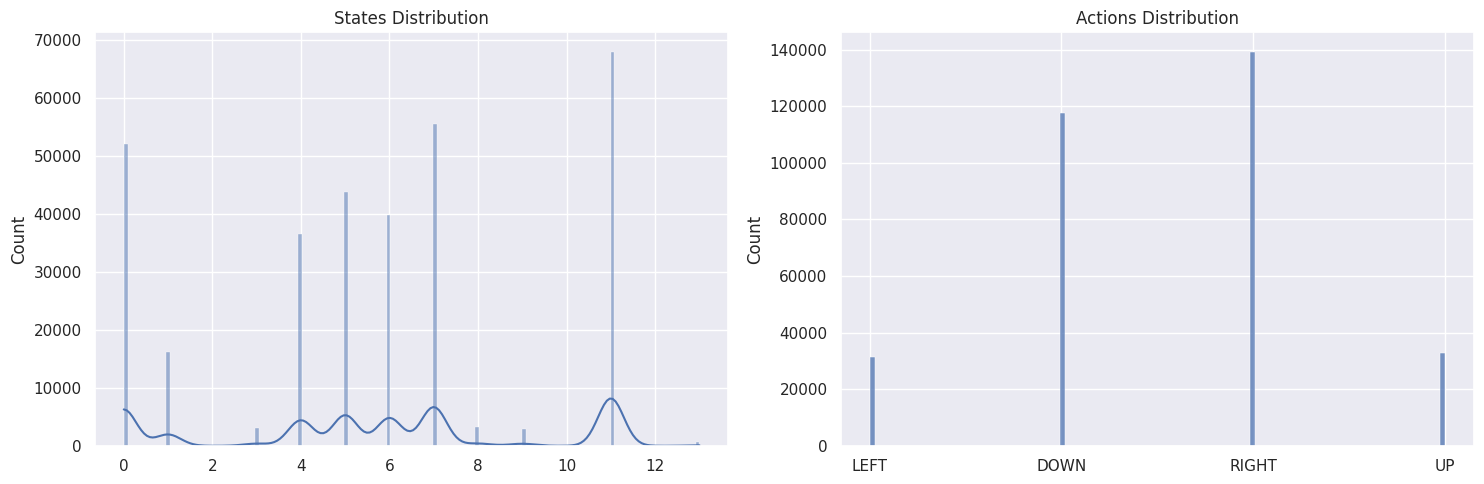

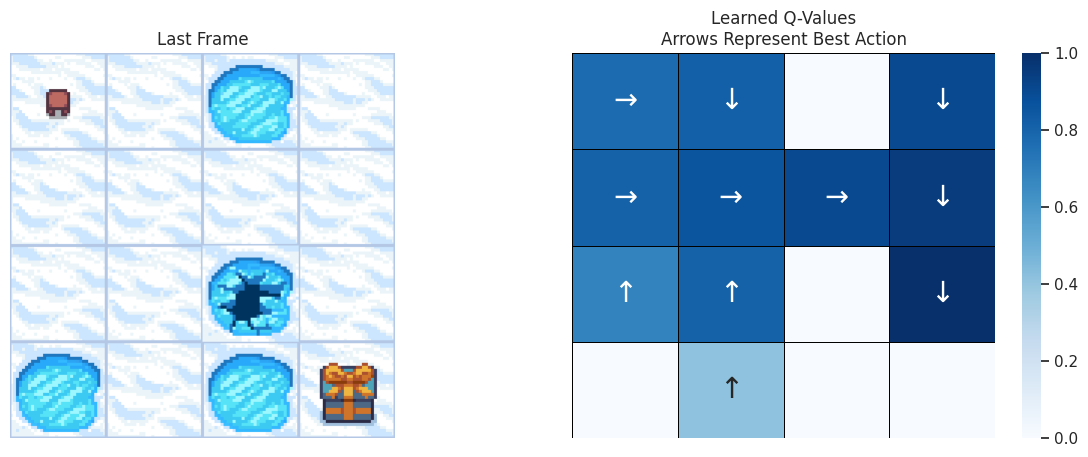

Executing for Grid Size: 7x7


Run 20/20 - Episodes: 100%|██████████| 2000/2000 [00:02<00:00, 919.52it/s] 


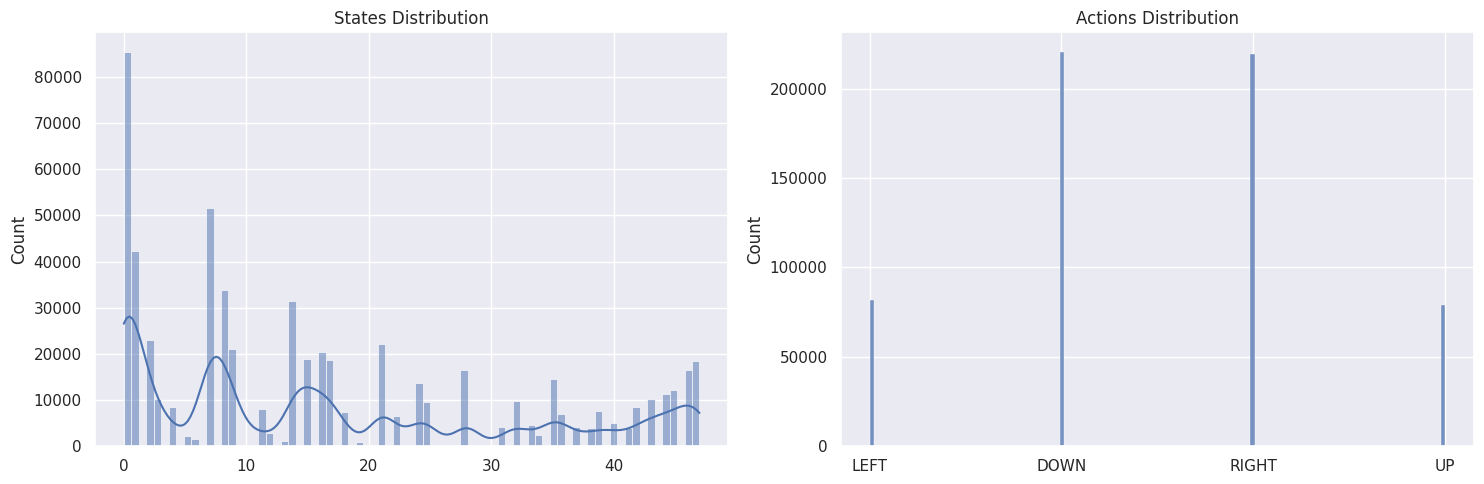

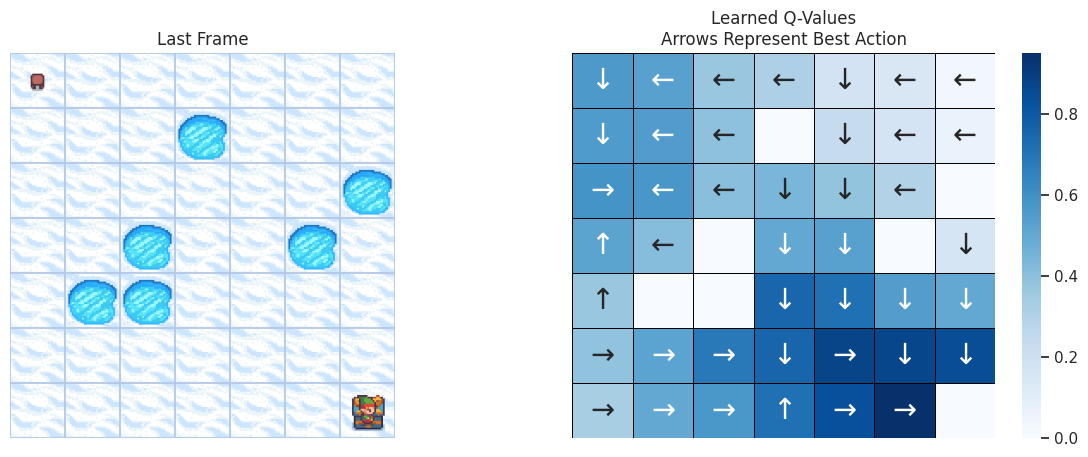

Executing for Grid Size: 9x9


Run 20/20 - Episodes: 100%|██████████| 2000/2000 [00:02<00:00, 804.77it/s]


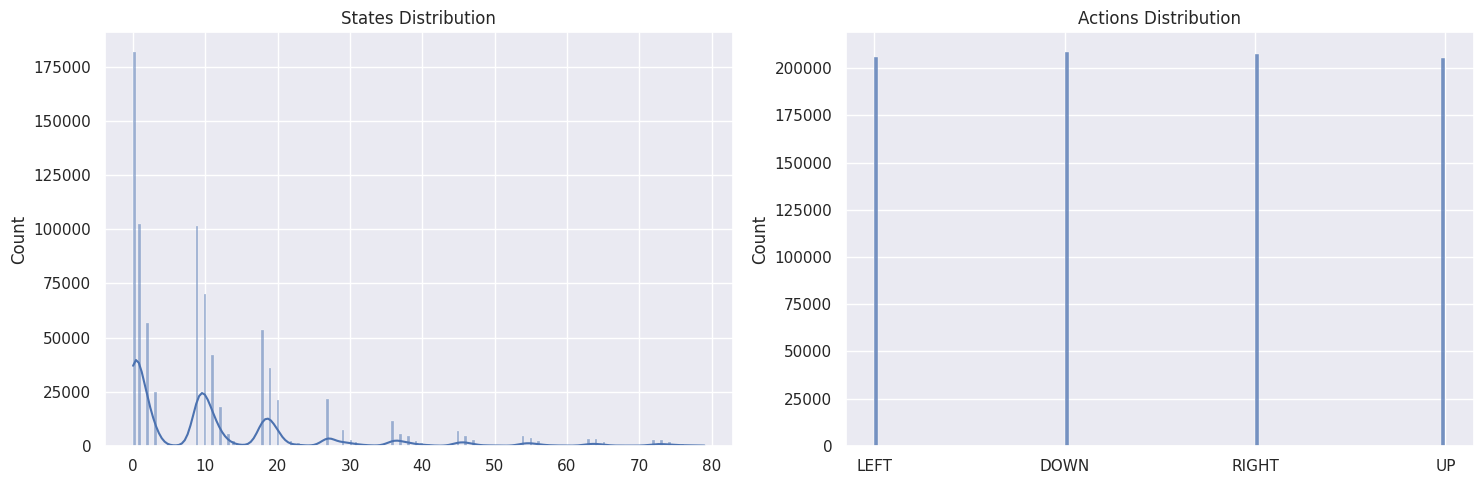

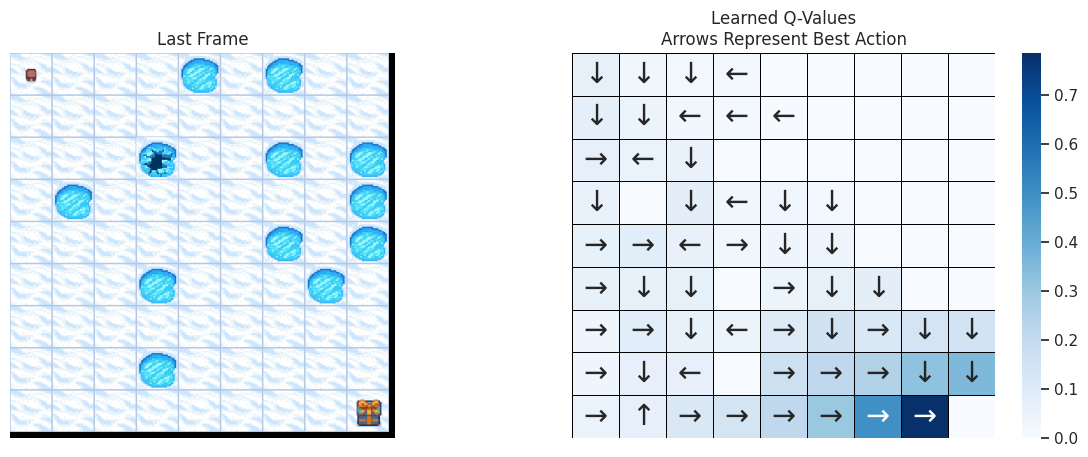

Executing for Grid Size: 11x11


Run 20/20 - Episodes: 100%|██████████| 2000/2000 [00:01<00:00, 1266.19it/s]


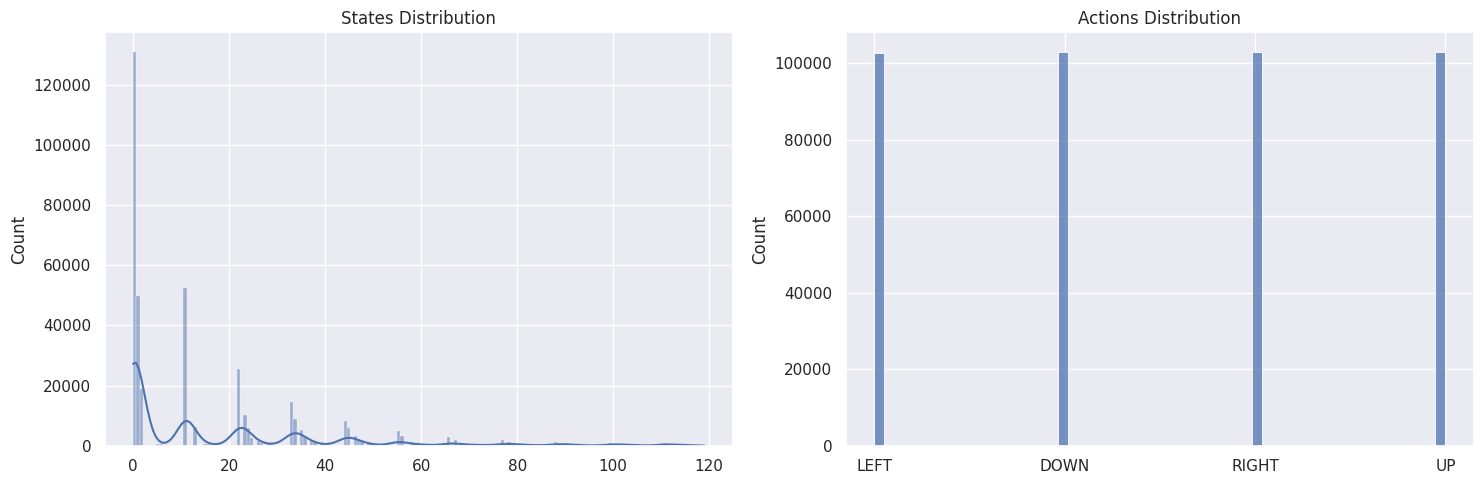

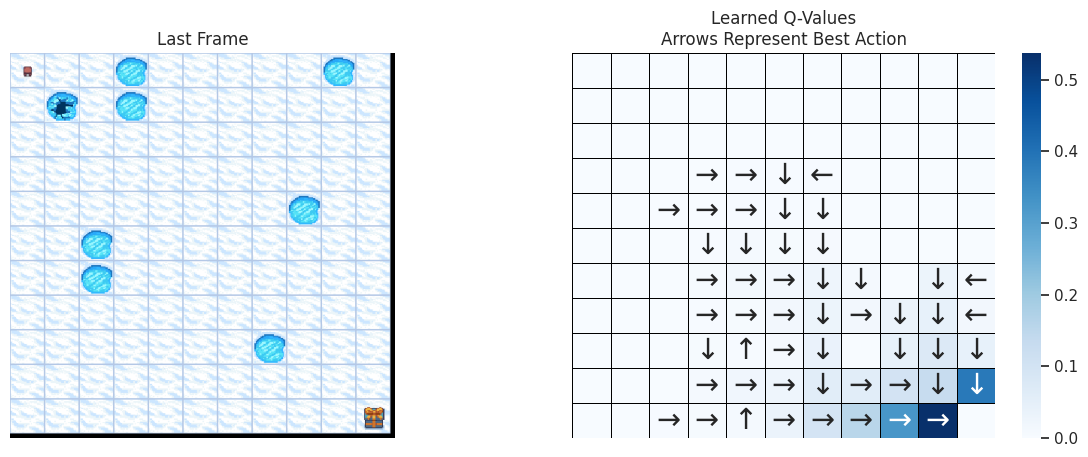

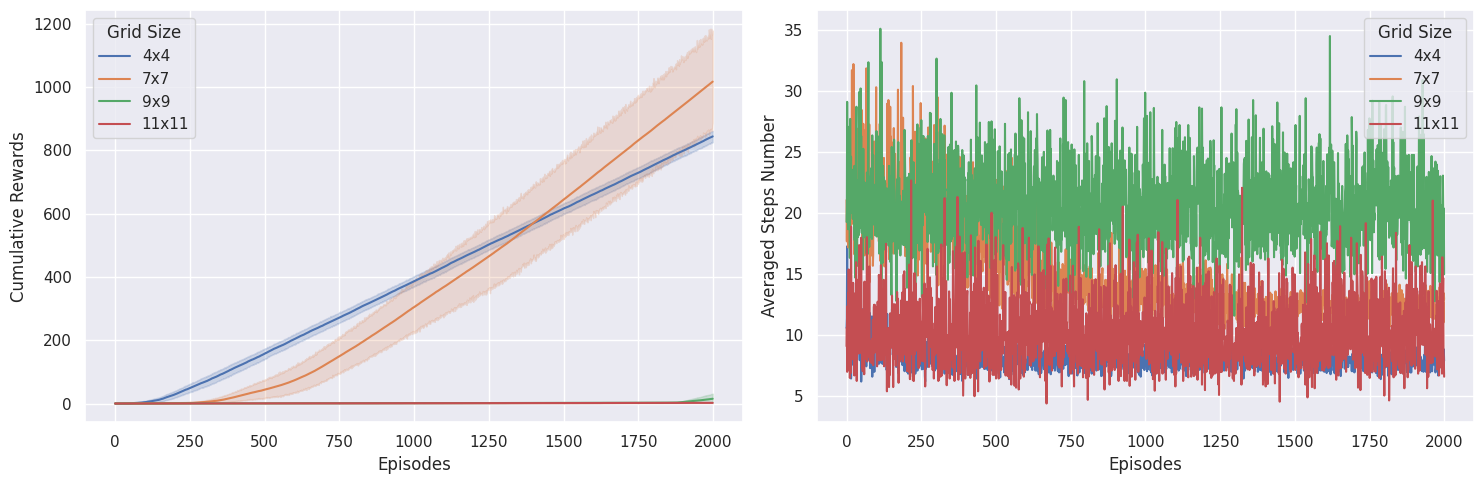

In [8]:

experiment_configuration.plot_output_directory.mkdir(parents=True, exist_ok=True)



experiment_configuration.plot_output_directory.mkdir(parents=True, exist_ok=True)

aggregated_reward_data = pd.DataFrame()
aggregated_step_data = pd.DataFrame()


for current_grid_size in grid_sizes:

    frozen_lake_environment = gym.make(
        "FrozenLake-v1",
        is_slippery=experiment_configuration.has_slippery_surface,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=current_grid_size,
            p=experiment_configuration.frozen_tile_probability,
        ),
    )

    experiment_configuration = experiment_configuration._replace(
        num_action_choices=frozen_lake_environment.action_space.n,
        num_state_choices=frozen_lake_environment.observation_space.n,
    )
    frozen_lake_environment.action_space.seed(experiment_configuration.random_seed)

    q_learning_agent = QLearningAlgorithm(
        learning_rate=experiment_configuration.learning_rate,
        discount_factor=experiment_configuration.discount_factor,
        num_states=experiment_configuration.num_state_choices,
        num_actions=experiment_configuration.num_action_choices,
    )
    epsilon_greedy_policy = EpsilonGreedyPolicy(exploration_rate=experiment_configuration.exploration_rate)

    print(f"Executing for Grid Size: {current_grid_size}x{current_grid_size}")


    (
        episode_rewards,
        episode_steps,
        episode_indices,
        q_table_collection,
        logged_states,
        logged_actions,
    ) = execute_q_learning_environment()


    reward_dataframe, step_dataframe = process_experiment_results(
        episode_indices=episode_indices,
        experiment_configuration=experiment_configuration,
        episode_rewards=episode_rewards,
        episode_steps=episode_steps,
        grid_dimension=current_grid_size,
    )
    aggregated_reward_data = pd.concat([aggregated_reward_data, reward_dataframe], ignore_index=True)
    aggregated_step_data = pd.concat([aggregated_step_data, step_dataframe], ignore_index=True)


    average_q_table = q_table_collection.mean(axis=0)
    plot_state_action_distributions(logged_states, logged_actions, current_grid_size)
    plot_q_table_values(average_q_table, frozen_lake_environment, current_grid_size)


    frozen_lake_environment.close()


plot_steps_and_rewards(aggregated_reward_data, aggregated_step_data)


In [9]:
def policy_iteration(env, gamma=1.0, max_iters=1000):
    policy = np.random.choice(env.action_space.n, size=(env.observation_space.n))
    for i in range(max_iters):
        values = evaluate_policy(policy, env, gamma)
        new_policy =improve_policy(values, env, gamma)
        if np.array_equal(policy, new_policy):
            print(f"Converged at iteration {i}.")
            break
        policy = new_policy
    return policy

def evaluate_policy(policy, environment, gamma=1.0, threshold=1e-10):
    values = np.zeros(environment.observation_space.n)
    while True:
        temp_values = values.copy()
        for state in range(environment.observation_space.n):
            action = policy[state]
            values[state] = sum(
                prob * (reward + gamma * temp_values[next_state])
                for prob, next_state, reward, _ in environment.P[state][action]  # Use unwrapped `P`
            )
        if np.sum(np.abs(temp_values - values)) <= threshold:
            break
    return values

def improve_policy(value_table, environment, gamma=1.0):
    policy = np.zeros(environment.observation_space.n, dtype=int)
    for state in range(environment.observation_space.n):
        q_values = np.zeros(environment.action_space.n)
        for action in range(environment.action_space.n):
            q_values[action] = sum(
                prob * (reward + gamma * value_table[next_state])
                for prob, next_state, reward, _ in environment.P[state][action]  # Use unwrapped `P`
            )
        policy[state] = np.argmax(q_values)
    return policy



Converged at iteration 19.
Converged at iteration 19.


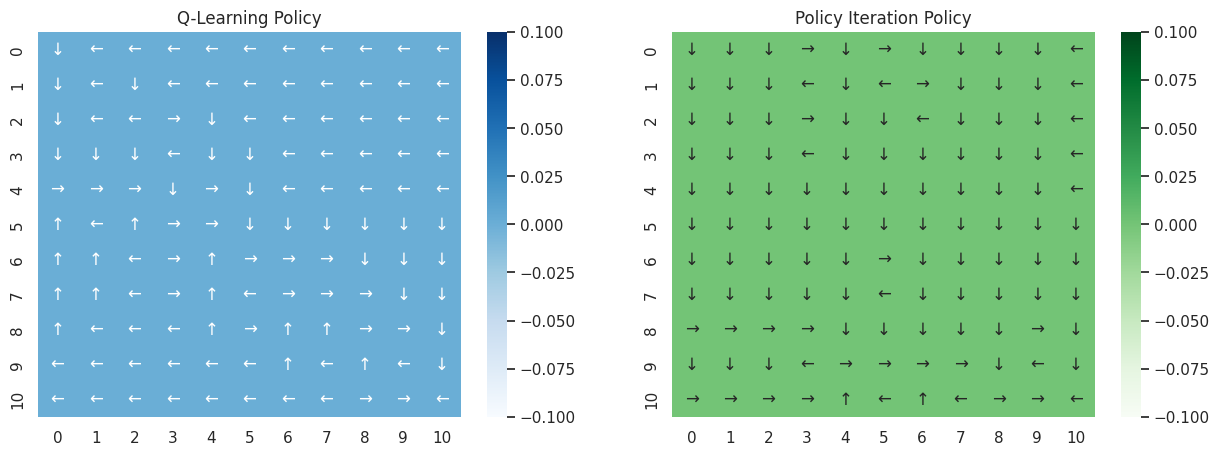

In [10]:

total_episodes = 2000

# Function to Compare Q-Learning and Policy Iteration Policies
def plot_policy_comparison(q_learning_policy, policy_iteration_policy, grid_dimension):
    """
    Compares policies derived from Q-Learning and Policy Iteration.

    Args:
        q_learning_policy: Policy derived from Q-Learning.
        policy_iteration_policy: Policy derived from Policy Iteration.
        grid_dimension: The size of the grid (grid_dimension x grid_dimension).
    """
    direction_symbols = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    q_learning_directions = np.array([direction_symbols[action] for action in q_learning_policy])
    policy_iteration_directions = np.array([direction_symbols[action] for action in policy_iteration_policy])

    q_learning_directions = q_learning_directions.reshape((grid_dimension, grid_dimension))
    policy_iteration_directions = policy_iteration_directions.reshape((grid_dimension, grid_dimension))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.heatmap(np.zeros((grid_dimension, grid_dimension)), annot=q_learning_directions, fmt="", ax=axes[0], cmap="Blues")
    axes[0].set_title("Q-Learning Policy")

    sns.heatmap(np.zeros((grid_dimension, grid_dimension)), annot=policy_iteration_directions, fmt="", ax=axes[1], cmap="Greens")
    axes[1].set_title("Policy Iteration Policy")

    plt.show()

# Compare Q-Learning and Policy Iteration Policies on FrozenLake
grid_dimension = 11  # Example grid dimension for comparison
# Create the FrozenLake environment
frozen_lake_environment = gym.make(
    "FrozenLake-v1",
    is_slippery=experiment_configuration.has_slippery_surface,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=grid_dimension,
        p=experiment_configuration.frozen_tile_probability,
    ),
)

# Unwrap the environment to access the core FrozenLakeEnv
unwrapped_environment = frozen_lake_environment.unwrapped

# Run Policy Iteration to derive the policy
policy_iteration_policy = policy_iteration(
    env=unwrapped_environment,  # Use the unwrapped environment
    gamma=experiment_configuration.discount_factor,
)


# Initialize Q-Learning
q_learning_agent = QLearningAlgorithm(
    learning_rate=experiment_configuration.learning_rate,
    discount_factor=experiment_configuration.discount_factor,
    num_states=frozen_lake_environment.observation_space.n,
    num_actions=frozen_lake_environment.action_space.n,
)
epsilon_greedy_policy = EpsilonGreedyPolicy(exploration_rate=experiment_configuration.exploration_rate)

# Run Q-Learning to derive the policy
for episode in range(total_episodes):
    current_state, _ = frozen_lake_environment.reset(seed=experiment_configuration.random_seed)
    is_episode_done = False

    while not is_episode_done:
        selected_action = epsilon_greedy_policy.select_action(
            action_space=frozen_lake_environment.action_space,
            current_state=current_state,
            q_table=q_learning_agent.q_table,
        )
        next_state, reward, is_terminal, is_truncated, _ = frozen_lake_environment.step(selected_action)
        is_episode_done = is_terminal or is_truncated

        q_learning_agent.q_table[current_state, selected_action] = q_learning_agent.compute_q_value_update(
            current_state, selected_action, reward, next_state
        )
        current_state = next_state

q_learning_policy = np.argmax(q_learning_agent.q_table, axis=1)

# Unwrap the environment to access the underlying dynamics
unwrapped_environment = frozen_lake_environment.unwrapped

# Run Policy Iteration to derive the policy
policy_iteration_policy = policy_iteration(
    env=unwrapped_environment,
    gamma=experiment_configuration.discount_factor,
)



# Adjust grid dimension based on the policy length if necessary
grid_dimension = int(np.sqrt(len(q_learning_policy)))  # Automatically calculate grid dimension

# Compare and visualize the policies
plot_policy_comparison(q_learning_policy, policy_iteration_policy, grid_dimension)

# Close the environment
frozen_lake_environment.close()


In [11]:
def perform_hyperparameter_tuning(environment, hyperparameter_values, experiment_config, hyperparameter_name):
    """
    Tune hyperparameters and calculate success rates.
    """
    results = {}

    for value in hyperparameter_values:
        print(f"Evaluating {hyperparameter_name} = {value}")

        updated_config = update_configuration(experiment_config, hyperparameter_name, value)
        agent = initialize_q_learning_agent(updated_config)
        policy_strategy = initialize_policy_strategy(updated_config)

        success_count = run_simulations(environment, agent, policy_strategy, updated_config.total_episodes)

        results[value] = calculate_success_rate(success_count, updated_config.total_episodes)

    return results


def update_configuration(config, parameter, value):
    """
    Update the configuration with the given hyperparameter value.
    """
    if parameter == "learning_rate":
        return config._replace(learning_rate=value)
    elif parameter == "discount_factor":
        return config._replace(discount_factor=value)
    elif parameter == "exploration_rate":
        return config._replace(exploration_rate=value)
    else:
        raise ValueError("Unsupported hyperparameter")


def initialize_q_learning_agent(config):
    """
    Initialize the Q-Learning agent with the configuration.
    """
    return QLearningAlgorithm(
        learning_rate=config.learning_rate,
        discount_factor=config.discount_factor,
        state_choices=config.state_choices,
        action_choices=config.action_choices,
    )


def initialize_policy_strategy(config):
    """
    Create an epsilon-greedy policy based on the exploration rate.
    """
    return EpsilonGreedyPolicy(config.exploration_rate)


def run_simulations(env, agent, policy, episodes):
    """
    Simulate episodes and return the count of successful outcomes.
    """
    success_count = 0

    for _ in range(episodes):
        current_state, _ = env.reset()
        is_episode_complete = False

        while not is_episode_complete:
            action = policy.select_action(
                action_space=env.action_space,
                current_state=current_state,
                q_table=agent.q_table,
            )
            next_state, reward, is_terminal, is_truncated, _ = env.step(action)
            is_episode_complete = is_terminal or is_truncated

            agent.q_table[current_state, action] = agent.compute_q_value_update(
                current_state, action, reward, next_state
            )
            current_state = next_state

            if is_episode_complete and reward > 0:
                success_count += 1

    return success_count


def calculate_success_rate(successes, total_episodes):
    """
    Calculate the success rate as a percentage.
    """
    return (successes / total_episodes) * 100


def visualize_hyperparameter_tuning(results, parameter_name):
    """
    Plot success rates against hyperparameter values.
    """
    values, rates = zip(*results.items())

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=values, y=rates, marker="o")
    plt.title(f"Effect of {parameter_name.replace('_', ' ').capitalize()} on Success Rate")
    plt.xlabel(parameter_name.replace('_', ' ').capitalize())
    plt.ylabel("Success Rate (%)")
    plt.grid(True)
    plt.show()

    for val, rate in results.items():
        print(f"{parameter_name.capitalize()}: {val}, Success Rate: {rate:.2f}%")


Evaluating learning_rate = 0.1


Running Episodes: 100%|██████████| 2000/2000 [00:00<00:00, 2145.94it/s]


Evaluating learning_rate = 0.2


Running Episodes: 100%|██████████| 2000/2000 [00:00<00:00, 2422.90it/s]


Evaluating learning_rate = 0.30000000000000004


Running Episodes: 100%|██████████| 2000/2000 [00:00<00:00, 2376.04it/s]


Evaluating learning_rate = 0.4


Running Episodes: 100%|██████████| 2000/2000 [00:00<00:00, 2053.60it/s]


Evaluating learning_rate = 0.5


Running Episodes: 100%|██████████| 2000/2000 [00:01<00:00, 1959.00it/s]


Evaluating discount_factor = 0.8


Running Episodes: 100%|██████████| 2000/2000 [00:01<00:00, 1922.32it/s]


Evaluating discount_factor = 0.8500000000000001


Running Episodes: 100%|██████████| 2000/2000 [00:00<00:00, 2202.90it/s]


Evaluating discount_factor = 0.9000000000000001


Running Episodes: 100%|██████████| 2000/2000 [00:00<00:00, 2177.98it/s]


Evaluating discount_factor = 0.9500000000000002


Running Episodes: 100%|██████████| 2000/2000 [00:00<00:00, 2178.82it/s]


Evaluating exploration_rate = 0.05


Running Episodes: 100%|██████████| 2000/2000 [00:00<00:00, 2391.38it/s]


Evaluating exploration_rate = 0.1


Running Episodes: 100%|██████████| 2000/2000 [00:00<00:00, 2357.94it/s]


Evaluating exploration_rate = 0.15000000000000002


Running Episodes: 100%|██████████| 2000/2000 [00:00<00:00, 2555.70it/s]


Evaluating exploration_rate = 0.2


Running Episodes: 100%|██████████| 2000/2000 [00:00<00:00, 2080.08it/s]


Evaluating exploration_rate = 0.25


Running Episodes: 100%|██████████| 2000/2000 [00:00<00:00, 2254.02it/s]


Evaluating exploration_rate = 0.3


Running Episodes: 100%|██████████| 2000/2000 [00:00<00:00, 2001.92it/s]


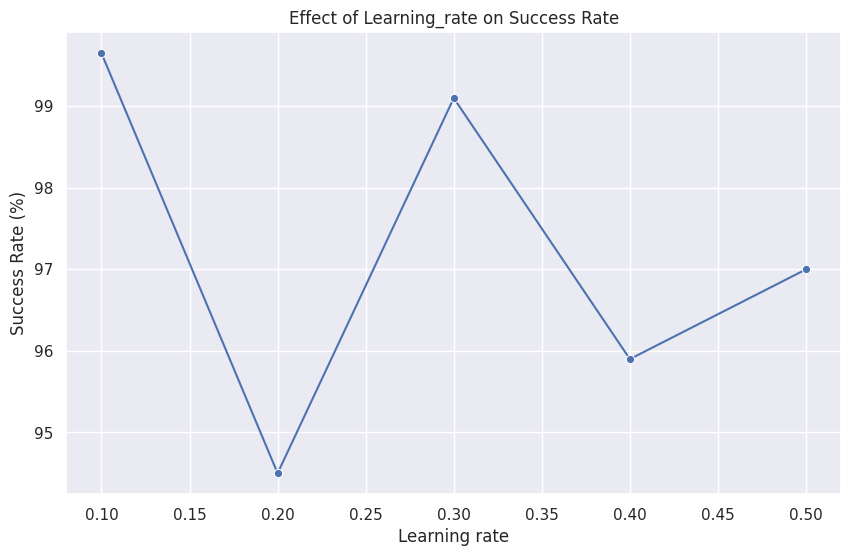

Learning_rate: 0.1, Success Rate: 99.65%
Learning_rate: 0.2, Success Rate: 94.50%
Learning_rate: 0.30000000000000004, Success Rate: 99.10%
Learning_rate: 0.4, Success Rate: 95.90%
Learning_rate: 0.5, Success Rate: 97.00%


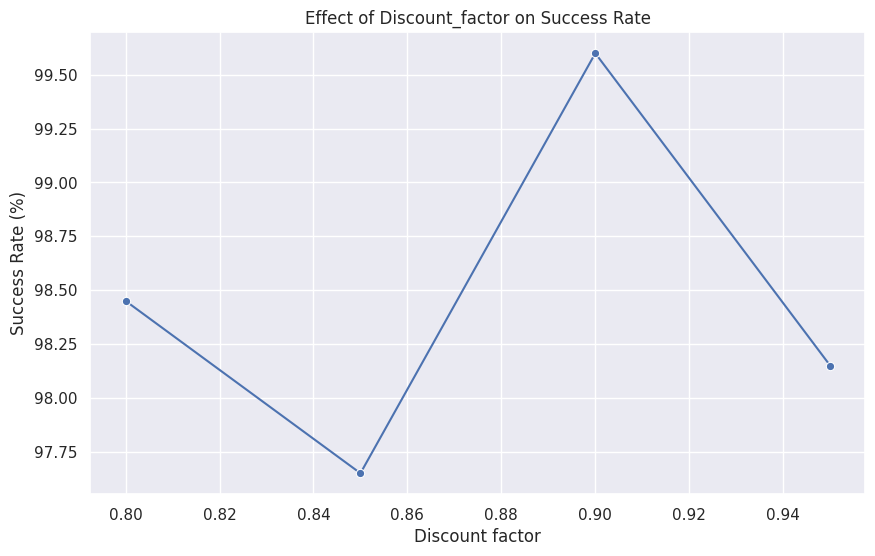

Discount_factor: 0.8, Success Rate: 98.45%
Discount_factor: 0.8500000000000001, Success Rate: 97.65%
Discount_factor: 0.9000000000000001, Success Rate: 99.60%
Discount_factor: 0.9500000000000002, Success Rate: 98.15%


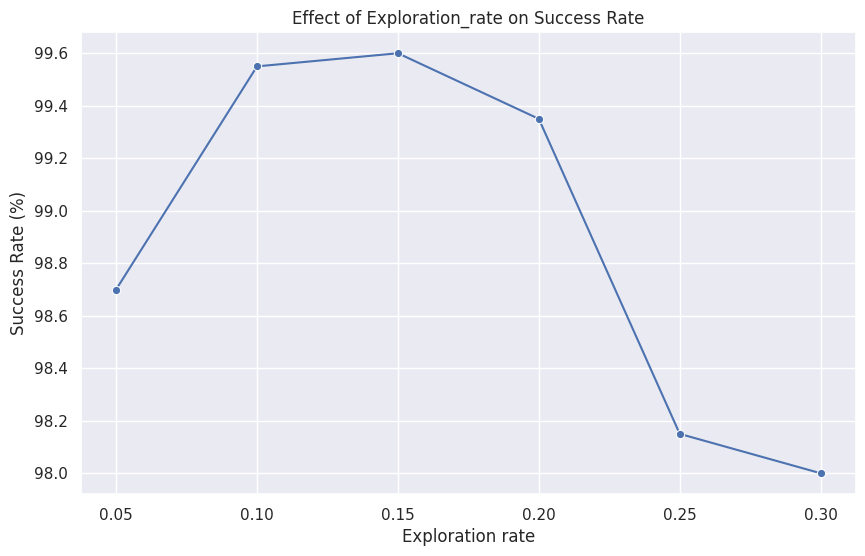

Exploration_rate: 0.05, Success Rate: 98.70%
Exploration_rate: 0.1, Success Rate: 99.55%
Exploration_rate: 0.15000000000000002, Success Rate: 99.60%
Exploration_rate: 0.2, Success Rate: 99.35%
Exploration_rate: 0.25, Success Rate: 98.15%
Exploration_rate: 0.3, Success Rate: 98.00%


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from tqdm import tqdm

# Hyperparameter tuning function
def execute_hyperparameter_tuning(environment, hyperparameter_values, experiment_config, hyperparameter_name):
    hyperparameter_results = {}

    for parameter_value in hyperparameter_values:
        print(f"Evaluating {hyperparameter_name} = {parameter_value}")

        adjusted_config = update_experiment_configuration(experiment_config, hyperparameter_name, parameter_value)
        q_learning_agent = initialize_q_learning_agent(adjusted_config)
        epsilon_policy = initialize_epsilon_greedy_policy(adjusted_config)

        successful_episode_count = simulate_environment(
            environment=environment,
            agent=q_learning_agent,
            policy=epsilon_policy,
            episode_limit=experiment_config.total_episodes
        )
        hyperparameter_results[parameter_value] = calculate_success_rate(successful_episode_count, experiment_config.total_episodes)

    return hyperparameter_results


def update_experiment_configuration(config, parameter_name, parameter_value):
    if parameter_name == "learning_rate":
        return config._replace(learning_rate=parameter_value)
    elif parameter_name == "discount_factor":
        return config._replace(discount_factor=parameter_value)
    elif parameter_name == "exploration_rate":
        return config._replace(exploration_rate=parameter_value)
    else:
        raise ValueError(f"Unsupported hyperparameter: {parameter_name}")


def initialize_q_learning_agent(config):
    return QLearningAlgorithm(
        learning_rate=config.learning_rate,
        discount_factor=config.discount_factor,
        num_states=config.num_state_choices,
        num_actions=config.num_action_choices,
    )


def initialize_epsilon_greedy_policy(config):
    return EpsilonGreedyPolicy(config.exploration_rate)


def simulate_environment(environment, agent, policy, episode_limit):
    successful_episodes = 0

    for _ in tqdm(range(episode_limit), desc="Running Episodes"):
        current_state, _ = environment.reset(seed=experiment_configuration.random_seed)
        is_episode_finished = False

        while not is_episode_finished:
            chosen_action = policy.select_action(
                action_space=environment.action_space,
                current_state=current_state,
                q_table=agent.q_table,
            )
            next_state, reward, is_terminal, is_truncated, _ = environment.step(chosen_action)
            is_episode_finished = is_terminal or is_truncated

            agent.q_table[current_state, chosen_action] = agent.compute_q_value_update(
                current_state, chosen_action, reward, next_state
            )
            current_state = next_state

            if is_episode_finished and reward > 0:
                successful_episodes += 1

    return successful_episodes


def calculate_success_rate(success_count, total_episodes):
    return (success_count / total_episodes) * 100


def visualize_tuning_results(hyperparameter_results, hyperparameter_name):
    parameter_values, success_rates = zip(*hyperparameter_results.items())

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=parameter_values, y=success_rates, marker="o")
    plt.title(f"Effect of {hyperparameter_name.capitalize()} on Success Rate")
    plt.xlabel(hyperparameter_name.replace('_', ' ').capitalize())
    plt.ylabel("Success Rate (%)")
    plt.grid(True)
    plt.show()

    for param_value, success_rate in hyperparameter_results.items():
        print(f"{hyperparameter_name.capitalize()}: {param_value}, Success Rate: {success_rate:.2f}%")


# Initialize the FrozenLake environment
frozen_lake_environment = gym.make(
    "FrozenLake-v1",
    is_slippery=experiment_configuration.has_slippery_surface,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=4,
        p=experiment_configuration.frozen_tile_probability,
    ),
)

# hyperparameter ranges
learning_rate_values = np.arange(0.1, 0.6, 0.1)
discount_factor_values = np.arange(0.8, 1.0, 0.05)
exploration_rate_values = np.arange(0.05, 0.35, 0.05)

#hyperparameter tuning
learning_rate_results = execute_hyperparameter_tuning(frozen_lake_environment, learning_rate_values, experiment_configuration, "learning_rate")
discount_factor_results = execute_hyperparameter_tuning(frozen_lake_environment, discount_factor_values, experiment_configuration, "discount_factor")
exploration_rate_results = execute_hyperparameter_tuning(frozen_lake_environment, exploration_rate_values, experiment_configuration, "exploration_rate")

# Visualize tuning results
visualize_tuning_results(learning_rate_results, "learning_rate")
visualize_tuning_results(discount_factor_results, "discount_factor")
visualize_tuning_results(exploration_rate_results, "exploration_rate")

# Close the environment
frozen_lake_environment.close()


Simulation Environment: CartPole-v1


Simulating Episodes: 100%|██████████| 5000/5000 [00:13<00:00, 375.15it/s]


Average Reward: 9.696
Median Reward: 10.0
Maximum Reward: 20.0
Minimum Reward: 8.0
Reward Statistics: {'average_reward': np.float64(9.696), 'total_episodes': 5000, 'highest_reward': np.float64(20.0), 'lowest_reward': np.float64(8.0)}


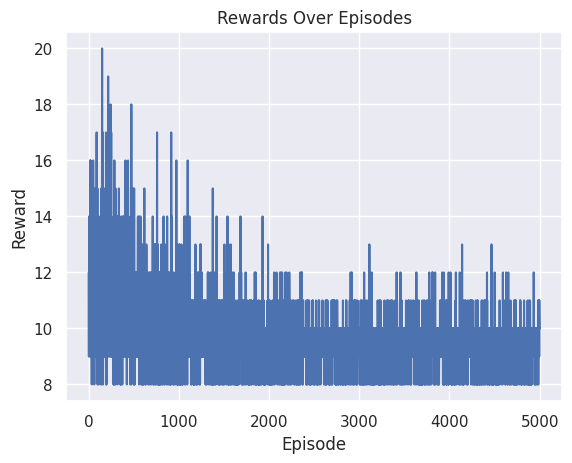

In [16]:


import gym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Compatibility fix for newer NumPy
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_


# Function to initialize Q-table
def initialize_q_table_for_environment_learning():
    return {}

# Function to generate a unique hash for the environment state
def generate_state_hash_from_environment_state(state_array):
    return str(state_array)

# Function to choose an action using epsilon-greedy strategy
def select_action_using_epsilon_greedy_policy(q_table, state_hash, total_available_actions, epsilon, is_testing_mode=False):
    if state_hash not in q_table:
        q_table[state_hash] = np.zeros(total_available_actions)
    if is_testing_mode or np.random.rand() < epsilon:
        return np.random.choice(total_available_actions)
    return np.argmax(q_table[state_hash])

# Function to update Q-table
def update_q_table_with_learning_formula(q_table, current_state_hash, selected_action, received_reward, next_state_hash, learning_rate, discount_factor, total_actions):
    if next_state_hash not in q_table:
        q_table[next_state_hash] = np.zeros(total_actions)
    current_q_value = q_table[current_state_hash][selected_action]
    max_future_q_value = np.max(q_table[next_state_hash])
    updated_q_value = current_q_value + learning_rate * (received_reward + discount_factor * max_future_q_value - current_q_value)
    q_table[current_state_hash][selected_action] = updated_q_value

# Function to decay epsilon value over time
def decay_epsilon_value_over_time(epsilon, decay_rate, min_epsilon):
    return max(epsilon * decay_rate, min_epsilon)

# Function to run a single episode simulation
def simulate_single_episode(environment, q_table, epsilon, learning_rate, discount_factor, max_steps):
    state = environment.reset()
    total_reward = 0
    for _ in range(max_steps):
        state_hash = generate_state_hash_from_environment_state(state)
        action = select_action_using_epsilon_greedy_policy(q_table, state_hash, environment.action_space.n, epsilon)
        next_state, reward, done, _ = environment.step(action)
        total_reward += reward
        next_state_hash = generate_state_hash_from_environment_state(next_state)
        update_q_table_with_learning_formula(q_table, state_hash, action, reward, next_state_hash, learning_rate, discount_factor, environment.action_space.n)
        state = next_state
        if done:
            break
    return total_reward

# Function to simulate multiple episodes
def simulate_environment_across_multiple_episodes(environment, episodes, learning_rate, discount_factor, epsilon, epsilon_decay, min_epsilon, max_steps):
    q_table = initialize_q_table_for_environment_learning()
    rewards_per_episode = []

    for _ in tqdm(range(episodes), desc="Simulating Episodes"):
        episode_reward = simulate_single_episode(environment, q_table, epsilon, learning_rate, discount_factor, max_steps)
        rewards_per_episode.append(episode_reward)
        epsilon = decay_epsilon_value_over_time(epsilon, epsilon_decay, min_epsilon)

    return rewards_per_episode, q_table

# Additional analysis functions
def analyze_reward_trends(rewards):
    print("Average Reward:", np.mean(rewards))
    print("Median Reward:", np.median(rewards))
    print("Maximum Reward:", np.max(rewards))
    print("Minimum Reward:", np.min(rewards))

# Function to generate reward statistics
def generate_reward_statistics(rewards):
    return {
        "average_reward": np.mean(rewards),
        "total_episodes": len(rewards),
        "highest_reward": np.max(rewards),
        "lowest_reward": np.min(rewards),
    }

# Main simulation execution function
def execute_simulation():
    simulation_params = {
        'episodes': 5000,
        'max_steps': 200,
        'learning_rate': 0.05,
        'discount_factor': 0.99,
        'epsilon': 0.3,
        'epsilon_decay': 0.999,
        'min_epsilon': 0.01
    }

    env = gym.make("CartPole-v1")
    print("Simulation Environment: CartPole-v1")

    rewards, q_table = simulate_environment_across_multiple_episodes(
        env,
        simulation_params['episodes'],
        simulation_params['learning_rate'],
        simulation_params['discount_factor'],
        simulation_params['epsilon'],
        simulation_params['epsilon_decay'],
        simulation_params['min_epsilon'],
        simulation_params['max_steps']
    )

    analyze_reward_trends(rewards)
    reward_stats = generate_reward_statistics(rewards)
    print("Reward Statistics:", reward_stats)

    plt.plot(rewards)
    plt.title("Rewards Over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.show()

    return rewards

# Execute the simulation
reward_results = execute_simulation()